In [52]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import numpy.polynomial.polynomial as poly
import gmaps
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm

from scipy.stats import linregress
from census import Census

# Census API Key
from config import api_key
c = Census(api_key, year=2017)

from config import gkey
gmaps.configure(api_key=gkey)

In [2]:
#Open the json file we extracted from TicketMaster

with open('Concerts.json', 'r') as myfile:
   data=myfile.read()
# parse file
obj = json.loads(data)
obj


{'_embedded': {'events': [{'_embedded': {'attractions': [{'_links': {'self': {'href': '/discovery/v2/attractions/K8vZ9173ea7?locale=en-us'}},
       'classifications': [{'family': False,
         'genre': {'id': 'KnvZfZ7vAee', 'name': 'R&B'},
         'primary': True,
         'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
         'subGenre': {'id': 'KZazBEonSMnZfZ7vkIt', 'name': 'R&B'},
         'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'},
         'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}}],
       'externalLinks': {'musicbrainz': [{'id': '8fb5370b-9568-4b61-9da5-2aa12c9928db'}],
        'wiki': [{'url': 'https://en.wikipedia.org/wiki/Lizzo'}]},
       'id': 'K8vZ9173ea7',
       'images': [{'fallback': False,
         'height': 225,
         'ratio': '4_3',
         'url': 'https://s1.ticketm.net/dam/a/87c/bf775ca2-e6cd-463a-9ff6-60459f33d87c_1094781_CUSTOM.jpg',
         'width': 305},
        {'fallback': False,
         'height': 360,
   

In [3]:
# Extract census data with API and save as a csv file

census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E"), {'for': 'zip code tabulation area:*'})

census_pd = pd.DataFrame(census_data)

census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name", "zip code tabulation area": "Zip Code"})

census_pd = census_pd[["Zip Code", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count"]]

# Visualize
print(len(census_pd))

# census_pd.to_csv("census_raw.csv", index=False)
census_pd.head()

33120


,Zip Code,Population,Median Age,Household Income,Per Capita Income,Poverty Count
0,00601,17599.0,38.9,11757.0,7041.0,11282.0
1,00602,39209.0,40.9,16190.0,8978.0,20428.0
2,00603,50135.0,40.4,16645.0,10897.0,25176.0
3,00606,6304.0,42.8,13387.0,5960.0,4092.0
4,00610,27590.0,41.4,18741.0,9266.0,12553.0


In [4]:
census_file = pd.read_csv('census_raw.csv')
census_pd = pd.DataFrame(census_file)

census_pd.dtypes

Zip Code               int64
Population           float64
Median Age           float64
Household Income     float64
Per Capita Income    float64
Poverty Count        float64
dtype: object

In [5]:
# # Clean up the census_raw dataframe


# Replace <0 values with 0
census_pd[census_pd <= 0] = np.nan

# Replace
census_pd.dropna(axis=0, how='any',inplace=True)
census_pd

census_pd.to_csv("cleaned_census_data.csv",index=False)

In [6]:
census_pd["Zip Code"] = census_pd['Zip Code'].astype(np.int64)

census_pd.dtypes
census_pd.describe()

,Zip Code,Population,Median Age,Household Income,Per Capita Income,Poverty Count
count,30215.000000,30215.000000,30215.000000,30215.000000,30215.000000,30215.000000
mean,49578.366209,10704.314844,42.172858,56408.290717,28814.039914,1559.377230
std,27395.568282,14877.344665,8.034520,23706.837261,12548.767046,2854.022318
min,601.000000,15.000000,9.200000,2499.000000,905.000000,1.000000
25%,27405.500000,1015.000000,37.000000,41307.500000,21542.000000,113.000000
50%,49795.000000,3553.000000,41.800000,51750.000000,26288.000000,411.000000
75%,71675.500000,15331.000000,46.600000,65493.000000,32635.500000,1686.000000
max,99929.000000,119204.000000,89.000000,250001.000000,254677.000000,38839.000000


In [20]:
Lizzo_concert = pd.read_csv("Lizzo_Concerts_NO_PHOENIX_Export_dataframe.csv")
Lizzo_concert_df = pd.DataFrame(Lizzo_concert)
Lizzo_concert_df



,Venue ID,City,Zip Code,Date,Genre Name,Genre ID,Max Ticket Price,Day of the Week
0,KovZpaKope,San Francisco,94102,10/27/2019,R&B,KnvZfZ7vAee,49.50,Sunday
1,KovZpZAFdJnA,Chicago,60640,9/28/2019,R&B,KnvZfZ7vAee,55.00,Saturday
2,KovZpaKope,San Francisco,94102,10/28/2019,R&B,KnvZfZ7vAee,69.50,Monday
3,KovZpZAEAlaA,Hollywood,90028,10/18/2019,R&B,KnvZfZ7vAee,99.50,Friday
4,KovZpZAJA6IA,San Diego,92182,10/24/2019,R&B,KnvZfZ7vAee,64.50,Thursday
5,KovZpZAEAFdA,Dallas,75215,10/5/2019,R&B,KnvZfZ7vAee,70.00,Saturday
6,KovZ917AQC0,Minneapolis,55415,10/9/2019,R&B,KnvZfZ7vAee,74.50,Wednesday
7,KovZ917AQC0,Minneapolis,55415,10/11/2019,R&B,KnvZfZ7vAee,74.50,Friday
8,KovZpZAFdJnA,Chicago,60640,9/29/2019,R&B,KnvZfZ7vAee,55.00,Sunday
9,KovZpZAEkIIA,Houston,77002,10/4/2019,R&B,KnvZfZ7vAee,92.75,Friday


In [21]:
Lizzo_concert_df['Zip Code'] = Lizzo_concert_df['Zip Code'].astype(np.int64)
Lizzo_concert_df.dtypes

Venue ID             object
City                 object
Zip Code              int64
Date                 object
Genre Name           object
Genre ID             object
Max Ticket Price    float64
Day of the Week      object
dtype: object

In [22]:
merged_df = pd.merge(census_pd, Lizzo_concert_df, on='Zip Code')
merged_df.to_csv('cleaned_cences_data_merged_with_Lizzo_Concert.csv')

In [10]:
merged_df

,Zip Code,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Venue ID,City,Date,Genre Name,Genre ID,Max Ticket Price,Day of the Week
0,37219,1060.0,41.8,73676.0,64868.0,96.0,KovZpa61Ge,Nashville,2019-09-30,R&B,KnvZfZ7vAee,70.00,Monday
1,40202,6827.0,36.3,17372.0,22211.0,2065.0,KovZpZAEk6tA,Louisville,2019-10-02,R&B,KnvZfZ7vAee,75.00,Wednesday
2,46204,7554.0,31.7,49757.0,38090.0,1159.0,KovZpZA6keIA,Indianapolis,2019-12-10,R&B,KnvZfZ7vAee,75.00,Tuesday
3,55415,4315.0,32.6,83793.0,60258.0,725.0,KovZ917AQC0,Minneapolis,2019-10-09,R&B,KnvZfZ7vAee,74.50,Wednesday
4,55415,4315.0,32.6,83793.0,60258.0,725.0,KovZ917AQC0,Minneapolis,2019-10-11,R&B,KnvZfZ7vAee,74.50,Friday
5,60640,68258.0,37.4,50488.0,39257.0,13808.0,KovZpZAFdJnA,Chicago,2019-09-28,R&B,KnvZfZ7vAee,55.00,Saturday
6,60640,68258.0,37.4,50488.0,39257.0,13808.0,KovZpZAFdJnA,Chicago,2019-09-29,R&B,KnvZfZ7vAee,55.00,Sunday
7,63112,19443.0,34.0,36638.0,25835.0,4621.0,KovZpZA6AJ7A,St Louis,2019-10-08,R&B,KnvZfZ7vAee,44.50,Tuesday
8,75215,15664.0,39.5,27358.0,17301.0,5344.0,KovZpZAEAFdA,Dallas,2019-10-05,R&B,KnvZfZ7vAee,70.00,Saturday
9,77002,12370.0,34.1,72306.0,34779.0,864.0,KovZpZAEkIIA,Houston,2019-10-04,R&B,KnvZfZ7vAee,92.75,Friday


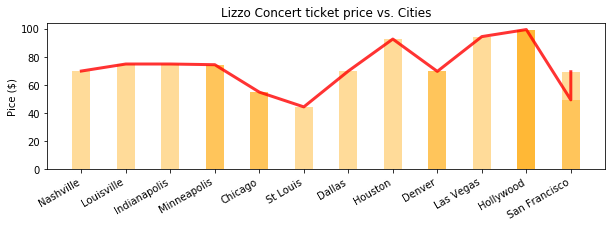

In [56]:
fig1 = plt.figure(figsize=(10,3))
plt.plot(merged_df['City'], merged_df['Max Ticket Price'], color = 'r', alpha= 0.8, linewidth=3.0)
plt.bar(merged_df['City'], merged_df['Max Ticket Price'], color= 'orange', alpha=0.4, width=0.4)
plt.title('Lizzo Concert ticket price vs. Cities')
plt.ylabel('Pice ($)')
fig1.autofmt_xdate()

plt.savefig('Lizzo Concert ticket price vs Cities.png')

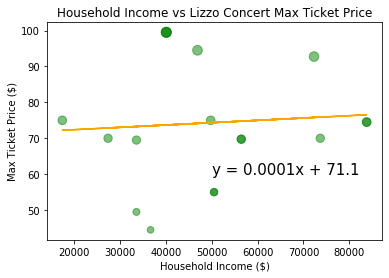

In [58]:
fig2 = plt.figure()

(slope, intercept, rvalue, pvalue, stderr) = linregress(merged_df['Household Income'], y= merged_df['Max Ticket Price'])
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2))
regress_values = merged_df['Household Income'] * slope + intercept
plt.scatter(x= merged_df['Household Income'], y= merged_df['Max Ticket Price'], color = 'green', 
            alpha= 0.5, s = merged_df['Max Ticket Price'])
plt.plot(merged_df['Household Income'], regress_values, '-', color='orange')
plt.annotate(line_eq,(50000,60),fontsize=15,color="black")
plt.xlabel('Household Income ($)')
plt.ylabel('Max Ticket Price ($)')
plt.title('Household Income vs Lizzo Concert Max Ticket Price')

plt.savefig('Household Income vs Lizzo Concert Max Ticket Price.png')

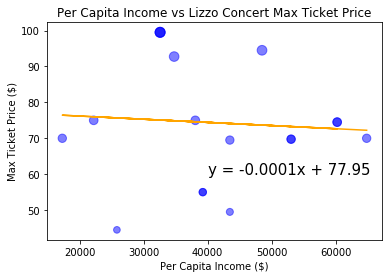

In [61]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(merged_df['Per Capita Income'], y= merged_df['Max Ticket Price'])
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2))
regress_values = merged_df['Per Capita Income'] * slope + intercept
plt.scatter(x= merged_df['Per Capita Income'], y= merged_df['Max Ticket Price'], color = 'blue', 
            alpha= 0.5, s = merged_df['Max Ticket Price'])
plt.plot(merged_df['Per Capita Income'], regress_values, '-', color='orange')
plt.annotate(line_eq,(40000,60),fontsize=15,color='black')
plt.xlabel('Per Capita Income ($)')
plt.ylabel('Max Ticket Price ($)')
plt.title('Per Capita Income vs Lizzo Concert Max Ticket Price')

plt.savefig('Per Capita Income vs Lizzo Concert Max Ticket Price.png')

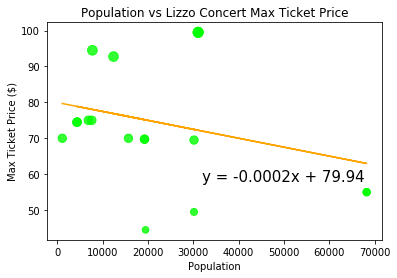

In [67]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(merged_df['Population'], y= merged_df['Max Ticket Price'])
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2))
regress_values = merged_df['Population'] * slope + intercept
plt.scatter(x= merged_df['Population'], y= merged_df['Max Ticket Price'], color = 'lime', 
            alpha= 0.8, s = merged_df['Max Ticket Price'])
plt.plot(merged_df['Population'], regress_values, '-', color='orange')
plt.annotate(line_eq,(32000,58),fontsize=15,color="black")
plt.xlabel('Population')
plt.ylabel('Max Ticket Price ($)')
plt.title('Population vs Lizzo Concert Max Ticket Price')

plt.savefig('Population vs Lizzo Concert Max Ticket Price.png')

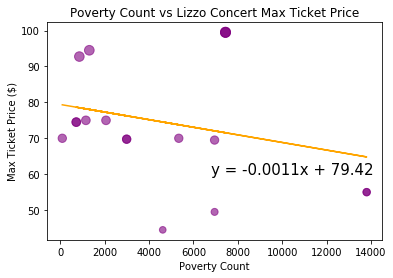

In [63]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(merged_df['Poverty Count'], y= merged_df['Max Ticket Price'])
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2))
regress_values = merged_df['Poverty Count'] * slope + intercept
plt.scatter(x= merged_df['Poverty Count'], y= merged_df['Max Ticket Price'], color = 'purple', 
            alpha= 0.6, s = merged_df['Max Ticket Price'])
plt.plot(merged_df['Poverty Count'], regress_values, '-', color='orange')
plt.annotate(line_eq,(6800,60),fontsize=15,color='black')
plt.xlabel('Poverty Count')
plt.ylabel('Max Ticket Price ($)')
plt.title('Poverty Count vs Lizzo Concert Max Ticket Price')

plt.savefig('Poverty Count vs Lizzo Concert Max Ticket Price.png')

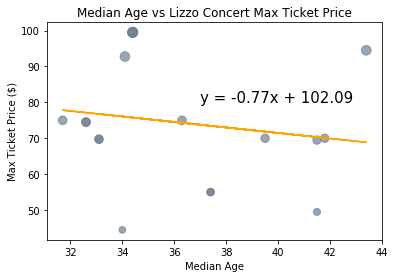

In [64]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(merged_df['Median Age'], y= merged_df['Max Ticket Price'])
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
regress_values = merged_df['Median Age'] * slope + intercept
plt.scatter(x= merged_df['Median Age'], y= merged_df['Max Ticket Price'], color = 'slategrey', 
            alpha= 0.7, s = merged_df['Max Ticket Price'])
plt.plot(merged_df['Median Age'], regress_values,'-', color='orange')
plt.annotate(line_eq,(37,80),fontsize=15,color= 'black')
plt.xlabel('Median Age')
plt.ylabel('Max Ticket Price ($)')
plt.title('Median Age vs Lizzo Concert Max Ticket Price')

plt.savefig('Median Age vs Lizzo Concert Max Ticket Price.png')

In [50]:
fig1 = plt.figure(figsize=(10,3))
averaged_price = merged_df.groupby('Day of the Week').mean()
# new_index = ["Monday", "Tuesday", "Wednesday", "Friday", "Saturday", "Sunday"]
# averaged_price.reset_index(new_index)

# cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# cat_type = CategoricalDtype(categories=cats, ordered=True)
# averaged_price['Day of the Week'] = averaged_price['Day of the Week'].astype(cat_type)
averaged_price = averaged_price.sort_values(by=['Max Ticket Price'])

<Figure size 720x216 with 0 Axes>

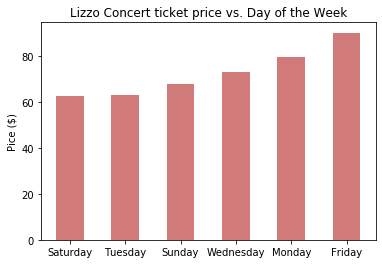

In [66]:
# plt.plot(averaged_price['Max Ticket Price'], color = 'r', alpha= 0.8, linewidth=3.0)


plt.bar(averaged_price.index, averaged_price['Max Ticket Price'], color= 'firebrick', alpha=0.6, width=0.5)
plt.title('Lizzo Concert ticket price vs. Day of the Week')
plt.ylabel('Pice ($)')
fig1.autofmt_xdate()

plt.savefig('Lizzo Concert ticket price vs. Day of the Week.png')

In [53]:
x_data = merged_df[['Median Age', 'Population', 'Per Capita Income']]
y_data = merged_df['Max Ticket Price']

x_data = sm.add_constant(x_data)
model = sm.OLS(y_data, x_data).fit()
predictions = model.predict(x_data)

print(model.summary())


C:\Users\Ziyan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Ziyan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:       Max Ticket Price   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                 -0.071
Method:                 Least Squares   F-statistic:                    0.6228
Date:                Wed, 02 Oct 2019   Prob (F-statistic):              0.612
Time:                        19:29:16   Log-Likelihood:                -75.062
No. Observations:                  18   AIC:                             158.1
Df Residuals:                      14   BIC:                             161.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               109.3291     43.89

In [ ]:
# fig = gmaps.figure(map_type="HYBRID")

# # Create heat layer
# locations = merged_df['Zip Code']
# price = merged_df['Max Ticket Price']

# heat_layer = gmaps.heatmap_layer(locations, weights = price, 
#                                  dissipating=False, max_intensity=10,
#                                  point_radius=1)

# fig.add_layer(heat_layer)
# fig